In [1]:
from __future__ import unicode_literals, print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from torch.utils import data
from torch.autograd import Variable
import warnings
import kornia
import radialProfile
import kornia
warnings.filterwarnings("ignore")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [28]:
# These experiments were all run where labels were permuted but FEATURES were not
# in_6_out_4 = torch.load("../../tf_net_results/karman_2d_input_6_output_4_permute_time_range_1_results.pt")
# int_6_out_10 = torch.load('../../tf_net_results/karman_2d_input_6_output_10_permute_time_range_2_results.pt')
# in_10_out_10 = torch.load("../../tf_net_results/karman_2d_input_10_output_10_permute_time_range_1_results.pt")

# Properly permuted features and labels
results_preds = torch.load('../../tf_net_results/karman_2d_input_1_output_400_permute_time_range_1_train_out4_preds.pt')
results_trues = torch.load('../../tf_net_results/karman_2d_input_1_output_400_permute_time_range_1_train_out4_trues.pt')
results_loss_curve = torch.load('../../tf_net_results/karman_2d_input_1_output_400_permute_time_range_1_train_out4_loss_curve.pt')
results2_preds = torch.load('../../tf_net_results/karman_2d_input_6_output_400_permute_time_range_2_train_out10_preds.pt')
results2_trues = torch.load('../../tf_net_results/karman_2d_input_6_output_400_permute_time_range_2_train_out10_trues.pt')
results2_loss_curve = torch.load('../../tf_net_results/karman_2d_input_6_output_400_permute_time_range_2_train_out10_loss_curve.pt')
results3_preds = torch.load('../../tf_net_results/karman_2d_input_10_output_400_permute_time_range_4_train_out10_preds.pt')
results3_trues = torch.load('../../tf_net_results/karman_2d_input_10_output_400_permute_time_range_4_train_out10_trues.pt')
results3_loss_curve = torch.load('../../tf_net_results/karman_2d_input_10_output_400_permute_time_range_4_train_out10_loss_curve.pt')
# results2 = torch.load('../../tf_net_results/karman_2d_input_10_output_10_permute_time_range_4.pt')
# results3 = torch.load('../../tf_net_results/karman_2d_input_1_output_4_permute_time_range_1.pt')
# results4 = torch.load('../../tf_net_results/karman_2d_input_1_output_1_permute_time_range_1.pt')
print(f'device: {device}')
#results_preds.keys()

device: cuda


In [29]:
colors = ["k", "tab:orange", "tab:blue", "tab:red", "tab:green", "tab:purple", "tab:brown", "tab:grey", "tab:pink", "tab:orange"]
title = ["Target", "Con TF-net", "TF-net", "U_net",  "GAN",  "ResNet", "ConvLSTM",  "SST",  "DHPM"]#"U_con",
markers = ['o',  "H", 'v', "*", "X", "d", "P",'s', "^"]

In [30]:
avg = 1.0424337
stds = 4522.7046
# multiply by stds and add avg to recover the prediction from normalization (z = (x-mean)/std)
# preds = [gan["trues"]*stds+avg, tf_con["preds"]*stds+avg, tf["preds"]*stds+avg, u["preds"]*stds+avg,  gan["preds"]*stds+avg,cnn["preds"]*stds+avg, convlstm["preds"]*stds+avg, sst["preds"]*stds+avg, dhpm["preds"]*stds+avg]
#preds = [results["trues"], results["preds"], results2["trues"], results2["preds"], results3["trues"], results3["preds"],
#        results4['trues'], results4['preds']]
preds = [results_trues, results_preds, results2_trues, results2_preds, results3_trues, results3_preds]
print([x.shape for x in preds])

[(450, 400, 2, 256, 128), (450, 400, 2, 256, 128), (450, 400, 2, 256, 128), (450, 400, 2, 256, 128), (450, 400, 2, 256, 128), (450, 400, 2, 256, 128)]


### RMSE vs. Prediction Steps

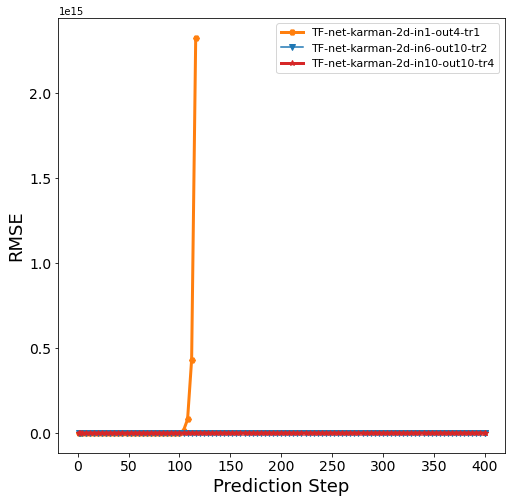

In [31]:
fig=plt.figure(figsize=(8, 8))
#idx = np.array([0,1] + list(range(3,60,4))+[59])
#idx = np.array([0,1] + list(range(3,10,4))+[9])
idx = np.array([0,1] + list(range(3,400,4))+[399])
plt.plot(idx+1, results_loss_curve[idx], label = "TF-net-karman-2d-in1-out4-tr1", marker=markers[1], linewidth = 3, color = colors[1])
plt.plot(idx+1, results2_loss_curve[idx], label = "TF-net-karman-2d-in6-out10-tr2", marker=markers[2], linewidth = 1.5, color = colors[2])
plt.plot(idx+1, results3_loss_curve[idx], label = "TF-net-karman-2d-in10-out10-tr4", marker=markers[3], linewidth = 3, color = colors[3])
# plt.plot(idx+1, results2['loss_curve'][idx], label = "TF-net-karman-2d-in10-out10-tr4", marker=markers[2], linewidth = 3, color = colors[2])
# plt.plot(idx+1, in_10_out_10['loss_curve'][idx], label = "TF-net-karman-in10-out10", marker=markers[2], linewidth = 3, color = colors[2])

plt.ylabel("RMSE", size = 18)
plt.xlabel("Prediction Step", size = 18)
plt.legend(fontsize=11)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.savefig("rmse_horizon.png", dpi = 400, bbox_inches = 'tight')
plt.show()

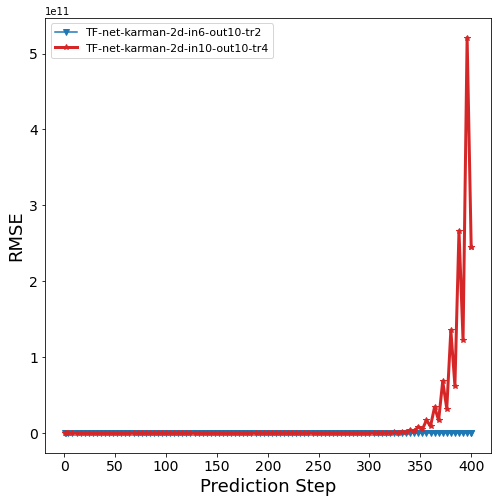

In [32]:
# Exclude very much outlier model in the plot
fig=plt.figure(figsize=(8, 8))
#idx = np.array([0,1] + list(range(3,60,4))+[59])
#idx = np.array([0,1] + list(range(3,10,4))+[9])
idx = np.array([0,1] + list(range(3,400,4))+[399])
plt.plot(idx+1, results2_loss_curve[idx], label = "TF-net-karman-2d-in6-out10-tr2", marker=markers[2], linewidth = 1.5, color = colors[2])
plt.plot(idx+1, results3_loss_curve[idx], label = "TF-net-karman-2d-in10-out10-tr4", marker=markers[3], linewidth = 3, color = colors[3])
# plt.plot(idx+1, results2['loss_curve'][idx], label = "TF-net-karman-2d-in10-out10-tr4", marker=markers[2], linewidth = 3, color = colors[2])
# plt.plot(idx+1, in_10_out_10['loss_curve'][idx], label = "TF-net-karman-in10-out10", marker=markers[2], linewidth = 3, color = colors[2])

plt.ylabel("RMSE", size = 18)
plt.xlabel("Prediction Step", size = 18)
plt.legend(fontsize=11)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.savefig("rmse_horizon.png", dpi = 400, bbox_inches = 'tight')
plt.show()

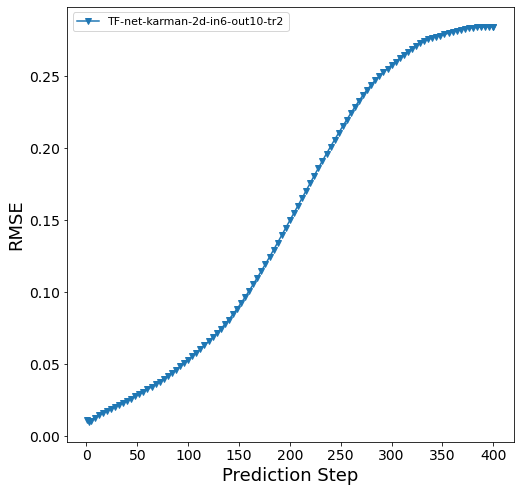

In [33]:
# Exclude very much outlier model in the plot
fig=plt.figure(figsize=(8, 8))
#idx = np.array([0,1] + list(range(3,60,4))+[59])
#idx = np.array([0,1] + list(range(3,10,4))+[9])
idx = np.array([0,1] + list(range(3,400,4))+[399])
plt.plot(idx+1, results2_loss_curve[idx], label = "TF-net-karman-2d-in6-out10-tr2", marker=markers[2], linewidth = 1.5, color = colors[2])
# plt.plot(idx+1, results2['loss_curve'][idx], label = "TF-net-karman-2d-in10-out10-tr4", marker=markers[2], linewidth = 3, color = colors[2])
# plt.plot(idx+1, in_10_out_10['loss_curve'][idx], label = "TF-net-karman-in10-out10", marker=markers[2], linewidth = 3, color = colors[2])

plt.ylabel("RMSE", size = 18)
plt.xlabel("Prediction Step", size = 18)
plt.legend(fontsize=11)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.savefig("rmse_horizon.png", dpi = 400, bbox_inches = 'tight')
plt.show()

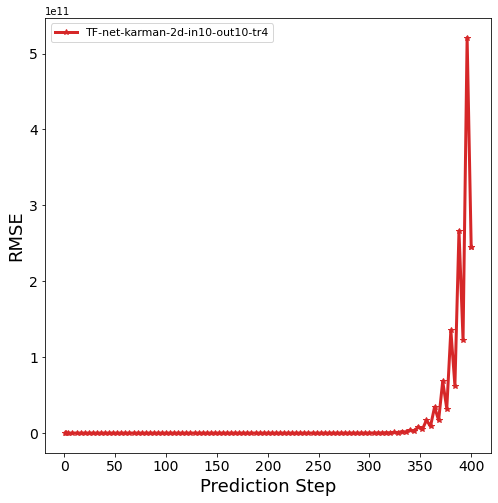

In [37]:
# Exclude very much outlier model in the plot
fig=plt.figure(figsize=(8, 8))
#idx = np.array([0,1] + list(range(3,60,4))+[59])
#idx = np.array([0,1] + list(range(3,10,4))+[9])
idx = np.array([0,1] + list(range(3,400,4))+[399])
# plt.plot(idx+1, results2_loss_curve[idx], label = "TF-net-karman-2d-in6-out10-tr2", marker=markers[2], linewidth = 1.5, color = colors[2])
plt.plot(idx+1, results3_loss_curve[idx], label = "TF-net-karman-2d-in10-out10-tr4", marker=markers[3], linewidth = 3, color = colors[3])

plt.ylabel("RMSE", size = 18)
plt.xlabel("Prediction Step", size = 18)
plt.legend(fontsize=11)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.savefig("rmse_horizon.png", dpi = 400, bbox_inches = 'tight')
plt.show()

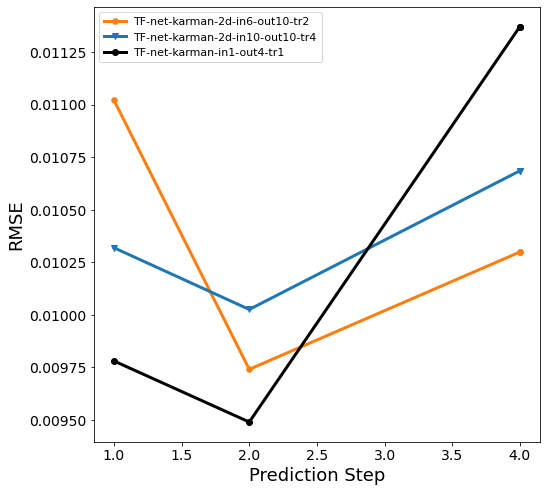

In [24]:
# Plot RMSE for output prediction of 4 steps
fig=plt.figure(figsize=(8, 8))
#idx = np.array([0,1] + list(range(3,60,4))+[59])
idx = np.array([0,1] + list(range(3,4,4))+[3])
plt.plot(idx+1, results['loss_curve'][idx], label = "TF-net-karman-2d-in6-out10-tr2", marker=markers[1], linewidth = 3, color = colors[1])
plt.plot(idx+1, results2['loss_curve'][idx], label = "TF-net-karman-2d-in10-out10-tr4", marker=markers[2], linewidth = 3, color = colors[2])
plt.plot(idx+1, results3['loss_curve'][idx], label = "TF-net-karman-in1-out4-tr1", marker=markers[0], linewidth = 3, color = colors[0])
# plt.plot(idx+1, int_6_out_10['loss_curve'][idx], label = "TF-net-karman-in6-out10", marker=markers[1], linewidth = 3, color = colors[1])
plt.ylabel("RMSE", size = 18)
plt.xlabel("Prediction Step", size = 18)
plt.legend(fontsize=11)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.savefig("rmse_horizon.png", dpi = 400, bbox_inches = 'tight')
plt.show()

### Kinetic Energy

In [38]:
def inverse_seqs(tensor):
    tensor = tensor.reshape(-1,7, 4, 2, 256, 128)
    #tensor = tensor.reshape(-1,7, 60, 2, 64, 64)
    tensor = tensor.transpose(0,2,3,1,4,5)
    tensor = tensor.transpose(0,1,2,4,3,5).reshape(-1, 4, 2, 64, 448)
    #tensor = tensor.transpose(0,1,2,4,3,5).reshape(-1, 60, 2, 64, 448)
    tensor = tensor.transpose(0,2,1,3,4)
    return tensor

def TKE(preds):
    mean_flow = np.expand_dims(np.mean(preds, axis = 1), axis = 1)
    tur_preds = np.mean((preds - mean_flow)**2, axis = 1)
    tke = (tur_preds[0] + tur_preds[1])/2
    return tke

def tke2spectrum(tke):
    """Convert TKE field to spectrum"""
    sp = np.fft.fft2(tke)
    sp = np.fft.fftshift(sp)
    sp = np.real(sp*np.conjugate(sp))
    sp1D = radialProfile.azimuthalAverage(sp)
    return sp1D 

def spectrum_band(tensor):
    tensor = inverse_seqs(tensor)
    spec = np.array([tke2spectrum(TKE(tensor[i])) for i in range(tensor.shape[0])])
    return np.mean(spec, axis = 0), np.std(spec, axis = 0)

def inverse_seqs(tensor):
    #tensor = tensor.reshape(-1,7, 60, 2, 64, 64)
    tensor = tensor.reshape(-1,7, 4, 2, 256, 128)
    tensor = tensor.transpose(0,2,3,1,4,5)
    #tensor = tensor.transpose(0,1,2,4,3,5).reshape(-1, 60, 2, 64, 448)
    tensor = tensor.transpose(0,1,2,4,3,5).reshape(-1, 4, 2, 64, 448)
    tensor = tensor.transpose(0,2,1,3,4)
    return tensor

def TKE_mean(tensor):
    if tensor.shape[-1] == 448:
        return TKE(tensor)
    print(f'tensor shape: {tensor.shape}')
    tensor = inverse_seqs(tensor)
    print(f'After inverse: {tensor.shape}')
    tke_mean = 0
    for i in range(0,min(70,tensor.shape[0])):
        tke_mean += TKE(tensor[i])
    tke_mean = tke_mean/tensor.shape[0]
    return tke_mean

tensor shape: (448, 400, 2, 256, 128)
After inverse: (51200, 2, 4, 64, 448)
tensor shape: (448, 400, 2, 256, 128)
After inverse: (51200, 2, 4, 64, 448)
tensor shape: (448, 400, 2, 256, 128)
After inverse: (51200, 2, 4, 64, 448)
tensor shape: (448, 400, 2, 256, 128)
After inverse: (51200, 2, 4, 64, 448)


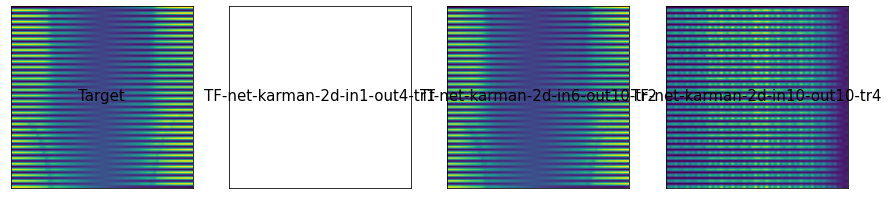

In [39]:
# the first dimension needs to be a multiple of 7 to work with inverse_seqs
# preds = [results["trues"][:2394], results["preds"][:2394], results2["trues"][:2394], results2["preds"][:2394],
#         results3["trues"][:2394], results3["preds"][:2394], results4["trues"][:2394], results4["preds"][:2394]]
preds = [results_trues[:448], results_preds[:448], results2_preds[:448], results3_preds[:448]]
tkes = [TKE_mean(preds[i]) for i in range(4)]
title = ["Target", "TF-net-karman-2d-in1-out4-tr1", "Tf-net-karman-2d-in6-out10-tr2", "TF-net-karman-2d-in10-out10-tr4"]
# title = ["Target-karman-2d-in6-out10-tr2", "TF-net-karman-in6-out10-tr2", "Target-karman-2d-in10-out10-tr4" ,"TF-net-karman-2d-in10-out10-tr4",
#         "Target-karman-2d-in1-out4-tr1", "TF-net-karman-in1-out4-tr1", "Target-karman-2d-in1-out1-tr1", "TF-net-karman-in1-out1-tr1"]
fig=plt.figure(figsize=(15, 5))
columns = 4
rows = 1
for i in range(columns):
    fig.add_subplot(rows, columns, i+1)
    #plt.imshow(tkes[i][:64,:448])
    #plt.imshow(tkes[i])
    plt.imshow(tkes[i][:64,:64])
    plt.xlabel(title[i], size = 15, rotation=0, labelpad = -100)
    plt.xticks([])
    plt.yticks([])
plt.savefig("Karman 2D Kinetic Energy.png", dpi = 400,bbox_inches = 'tight')
plt.show()

### Divergence 

In [40]:
def divergence(preds):
    #preds: batch_size*output_steps*2*H*W
    print(f'preds.shape: {preds.shape}')
    preds_u = preds[:,:,0]
    preds_v = preds[:,:,1]
    u = torch.from_numpy(preds_u).float().to(device)
    v = torch.from_numpy(preds_v).float().to(device)
    #Sobolev gradients
    field_grad = kornia.filters.SpatialGradient()
    u_x = field_grad(u)[:,:,0]
    v_y = field_grad(v)[:,:,1]
    div = np.mean(np.abs((v_y + u_x).cpu().data.numpy()), axis = (0,2,3))
    return div

In [41]:
# print(results["preds"].shape)
# Need to reduce batch size otherwise it causes problems
#preds = [results["trues"], results["preds"]]
#dhpm_preds = np.expand_dims(results["preds"].transpose(1,0,2,3), axis = 0)
divs = [divergence(preds[i]) for i in range(4)]
linestyles = ['-', '--', '-.', ':','-.', '--', '-.', ':','-.','--']
fig=plt.figure(figsize=(8, 8))
#idx = np.array(list(range(0,60,4)))
idx = np.array(list(range(0,400,4)))
#for i in range(1, len(markers)):
plt.plot(idx+1, divs[1][idx], label = title[1], marker=markers[1], linewidth = 2, linestyle=':', color = colors[1])  
plt.plot(idx+1, divs[0][idx], label = title[0], marker=markers[0], linewidth = 2, linestyle=linestyles[0], color = 'k')
plt.plot(idx+1, divs[3][idx], label = title[3], marker=markers[2], linewidth = 2, linestyle=':', color = colors[2])  
plt.plot(idx+1, divs[2][idx], label = title[2], marker=markers[3], linewidth = 2, linestyle=linestyles[0], color = 'k')
# plt.plot(idx+1, divs[5][idx], label = title[5], marker=markers[4], linewidth = 2, linestyle=':', color = colors[3])  
# plt.plot(idx+1, divs[4][idx], label = title[4], marker=markers[5], linewidth = 2, linestyle=linestyles[0], color = 'k')

plt.ylabel("Mean Absolute Divergence", size = 18)
plt.xlabel("Prediction Step", size = 18)
plt.legend(fontsize=11)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig("karman-2d-divergence.png", dpi = 400, bbox_inches = 'tight')
plt.show()

preds.shape: (448, 400, 2, 256, 128)


RuntimeError: CUDA out of memory. Tried to allocate 21.88 GiB (GPU 0; 10.76 GiB total capacity; 0 bytes already allocated; 5.46 GiB free; 0 bytes reserved in total by PyTorch)

### Energy Spectrum

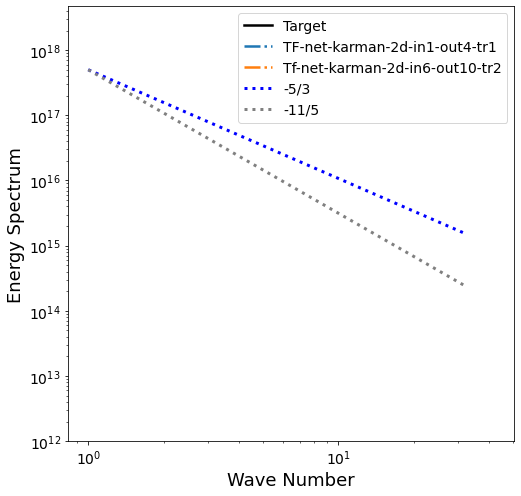

In [42]:
def inverse_seqs(tensor):
    #tensor = tensor.reshape(-1,7, 60, 2, 64, 64)
    tensor = tensor.reshape(-1,7, 4, 2, 256, 128)
    tensor = tensor.transpose(0,2,3,1,4,5)
    #tensor = tensor.transpose(0,1,2,4,3,5).reshape(-1, 60, 2, 64, 448)
    tensor = tensor.transpose(0,1,2,4,3,5).reshape(-1, 4, 2, 64, 448)
    tensor = tensor[:,:,:,:,:64]
    tensor = tensor.transpose(0,2,1,3,4)
    return tensor

#preds = [results["trues"][:2394], results["preds"][:2394]]

fig=plt.figure(figsize=(8, 8))
spec_mean, spec_stds = spectrum_band(preds[0])
x_idx = np.array(list(range(0,len(spec_mean))))
plt.plot(x_idx, spec_mean[x_idx], label = title[0], linewidth = 2.5, color = "k")

spec_mean, spec_stds = spectrum_band(preds[1])
plt.plot(x_idx, spec_mean[x_idx], label = title[1], linewidth = 2.5, color = colors[2], linestyle='-.')

spec_mean, spec_stds = spectrum_band(preds[2])
plt.plot(x_idx, spec_mean[x_idx], label = title[2], linewidth = 2.5, color = colors[1], linestyle='-.')

spec_mean, spec_stds = spectrum_band(preds[3])
# plt.plot(x_idx, spec_mean[x_idx], label = title[3], linewidth = 2.5, color = colors[3], linestyle='-.')

# spec_mean, spec_stds = spectrum_band(preds[4])
# plt.plot(x_idx, spec_mean[x_idx], label = title[4], linewidth = 2.5, color = colors[4], linestyle='-.')

# spec_mean, spec_stds = spectrum_band(preds[5])
# plt.plot(x_idx, spec_mean[x_idx], label = title[5], linewidth = 2.5, color = colors[5], linestyle='-.')

# spec_mean, spec_stds = spectrum_band(preds[6])
# plt.plot(x_idx, spec_mean[x_idx], label = title[6], linewidth = 2.5, color = colors[6], linestyle='-.')

# spec_mean, spec_stds = spectrum_band(preds[7])
# plt.plot(x_idx, spec_mean[x_idx], label = title[7], linewidth = 2.5, color = colors[7], linestyle='-.')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.yscale("log")
plt.xscale("log")
x_idx = np.linspace(0,5,100)
x = 2**x_idx
y = 2**(-5*x_idx/3 + np.log2(5*10e16))
plt.plot(x, y, ':b', label='-5/3',linewidth = 3)

x_idx = np.linspace(0,5,100)
x = 2**x_idx
y = 2**(-11*x_idx/5 + np.log2(5*10e16))
plt.plot(x, y, ':', label='-11/5',linewidth = 3, color = "grey")

plt.legend(fontsize=14, loc = 1)
plt.ylabel("Energy Spectrum", size = 18)
plt.xlabel("Wave Number", size = 18)
plt.ylim(10e11, )
plt.savefig("karman_2d_spec_ci_entire.png", dpi = 400, bbox_inches = 'tight')

Text(0.5, 0, 'Wave Number')

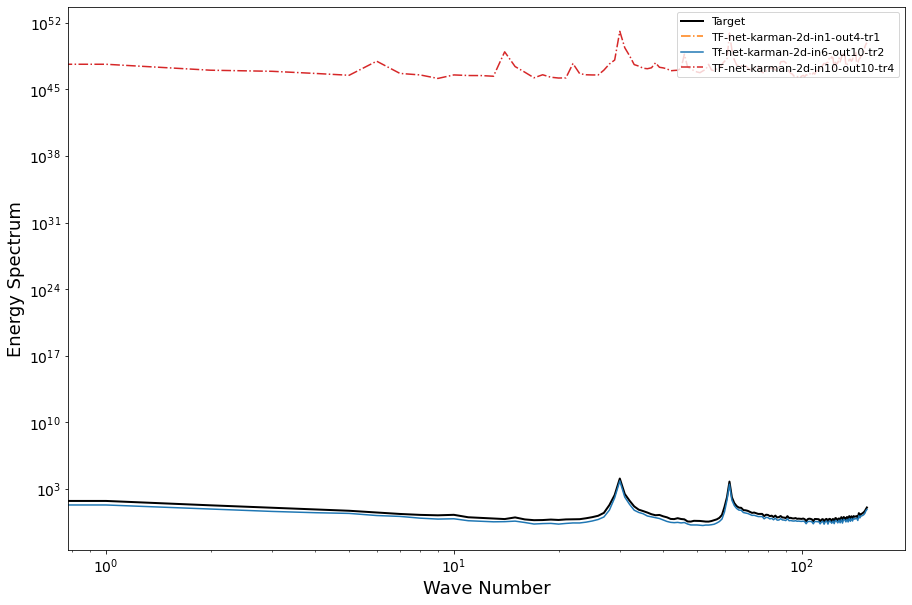

In [43]:
def inverse_seqs(tensor):
    #tensor = tensor.reshape(-1,7, 60, 2, 64, 64)
    tensor = tensor.reshape(-1,7, 4, 2, 256, 128)
    tensor = tensor.transpose(0,2,3,1,4,5)
    #tensor = tensor.transpose(0,1,2,4,3,5).reshape(-1, 60, 2, 64, 448)
    tensor = tensor.transpose(0,1,2,4,3,5).reshape(-1, 4, 2, 64, 448)
    tensor = tensor.transpose(0,2,1,3,4)
    return tensor

#preds = [results["trues"][:2394], results["preds"][:2394], results2["trues"][:2394], results2["preds"][:2394]]

#title = ["Target-karman-2d", "TF-net-karman-2d"]
fig=plt.figure(figsize=(15, 10))
x_idx = np.array(list(range(0,155)))

spec_mean, spec_stds = spectrum_band(preds[0])
plt.plot(x_idx, spec_mean[x_idx], label = title[0], linewidth = 2, color = "k")

for i in range(1, 4):
    spec_mean, spec_stds = spectrum_band(preds[i])
    if i % 2 == 1 :
        plt.plot(x_idx, spec_mean[x_idx], label = title[i], linewidth = 1.5, color = colors[i], linestyle='-.')
    else:
        plt.plot(x_idx, spec_mean[x_idx], label = title[i], linewidth = 1.5, color = colors[i])

plt.legend(fontsize=11, loc = 1)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.yscale("log")
plt.xscale("log")
plt.ylabel("Energy Spectrum", size = 18)
plt.xlabel("Wave Number", size = 18)
#plt.savefig("spec_ci_all.png", dpi = 400, bbox_inches = 'tight')

### Visualization

preds shape: (450, 400, 2, 256, 128)
labels shape: (450, 400, 2, 256, 128)
loss shape: (400,)


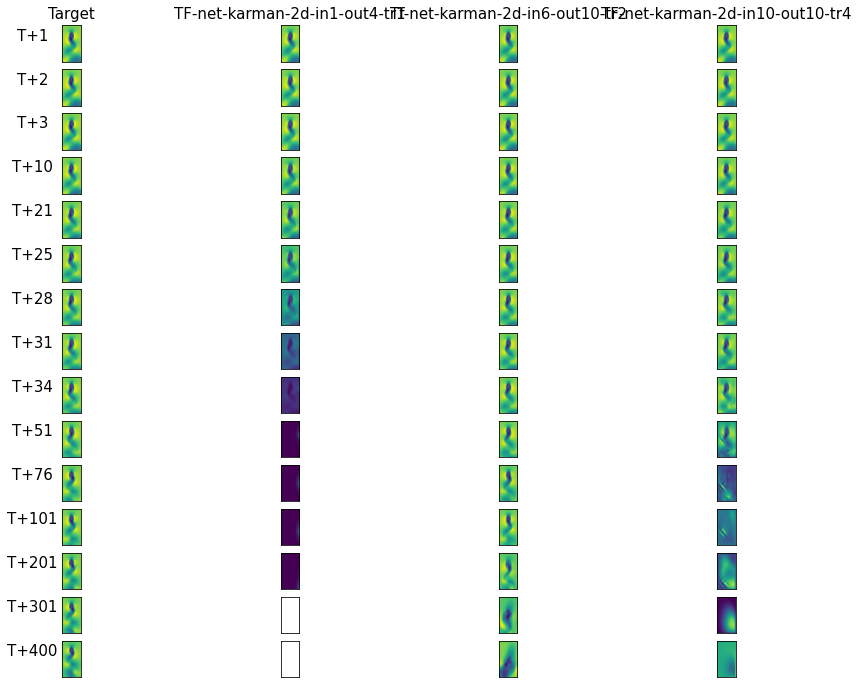

In [44]:
index = 0
direc = 0
print(f'preds shape: {results_preds.shape}')
print(f'labels shape: {results_trues.shape}')
print(f'loss shape: {results_loss_curve.shape}')
#timesteps = [0,1,2, 4,9,19,59]
#timesteps = [0,1,2, 3, 4, 5, 6, 7, 8, 9]
timesteps = [0,1,2, 9, 20, 24, 27, 30, 33, 50, 75, 100, 200, 300, 399]
fig=plt.figure(figsize=(15, 12))
columns = 4
rows = len(timesteps)
for i in range(1, rows+1):
    for j in range(1, columns+1):
        fig.add_subplot(rows, columns, (i-1)*columns+j)
        #print(f'i : {i}, j: {j}')
        if j == 11:
             plt.imshow(preds[j-1][direc,timesteps[i-1],:64,:64])
        else:
            if j == 1:
                plt.imshow(preds[j-1][index][timesteps[i-1],direc])
                plt.ylabel("T+"+str(timesteps[i-1]+1), size = 15 ,rotation=0, labelpad=30)
                #plt.imshow(preds[j-1][direc,timesteps[i-1],:64,:64])
            else:
                plt.imshow(preds[j-1][index][timesteps[i-1],direc])
        
        if i == 1:
            plt.title(title[j-1], size = 15)
        plt.xticks([])
        plt.yticks([])
plt.savefig("karman-2d-velocity_u.png", dpi = 400, bbox_inches = 'tight')
plt.show()

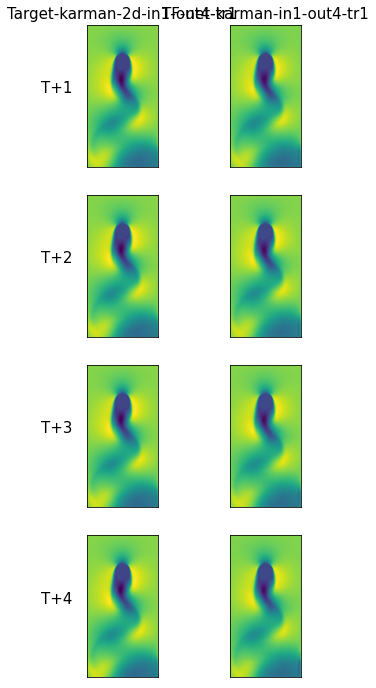

In [20]:
# For output prediction 4
index = 0
direc = 0
#timesteps = [0,1,2, 4,9,19,59]
#timesteps = [0,1,2, 3, 4, 5, 6, 7, 8, 9]
timesteps = [0,1,2, 3]
fig=plt.figure(figsize=(15, 12))
columns = 6
rows = len(timesteps)
for i in range(1, rows+1):
    for j in range(5, columns+1):
        fig.add_subplot(rows, columns, (i-1)*columns+j)
        #print(f'i : {i}, j: {j}')
        if j == 11:
             plt.imshow(preds[j-1][direc,timesteps[i-1],:64,:64])
        else:
            if j == 5:
                plt.imshow(preds[j-1][index][timesteps[i-1],direc])
                plt.ylabel("T+"+str(timesteps[i-1]+1), size = 15 ,rotation=0, labelpad=30)
                #plt.imshow(preds[j-1][direc,timesteps[i-1],:64,:64])
            else:
                plt.imshow(preds[j-1][index][timesteps[i-1],direc])
        
        if i == 1:
            plt.title(title[j-1], size = 15)
        plt.xticks([])
        plt.yticks([])
plt.savefig("karman-2d-velocity_u.png", dpi = 400, bbox_inches = 'tight')
plt.show()

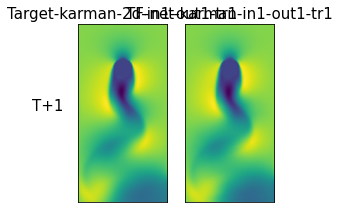

In [23]:
# For output prediction 1
index = 0
direc = 0
#timesteps = [0,1,2, 4,9,19,59]
#timesteps = [0,1,2, 3, 4, 5, 6, 7, 8, 9]
timesteps = [0]
fig=plt.figure(figsize=(15, 12))
columns = 8
rows = len(timesteps)
for i in range(1, rows+1):
    for j in range(7, columns+1):
        fig.add_subplot(rows, columns, (i-1)*columns+j)
        #print(f'i : {i}, j: {j}')
        if j == 11:
             plt.imshow(preds[j-1][direc,timesteps[i-1],:64,:64])
        else:
            if j == 7:
                plt.imshow(preds[j-1][index][timesteps[i-1],direc])
                plt.ylabel("T+"+str(timesteps[i-1]+1), size = 15 ,rotation=0, labelpad=30)
                #plt.imshow(preds[j-1][direc,timesteps[i-1],:64,:64])
            else:
                plt.imshow(preds[j-1][index][timesteps[i-1],direc])
        
        if i == 1:
            plt.title(title[j-1], size = 15)
        plt.xticks([])
        plt.yticks([])
plt.savefig("karman-2d-velocity_u.png", dpi = 400, bbox_inches = 'tight')
plt.show()

## Videos

In [ ]:
direc = "/global/cscratch1/sd/rwang2/TF-net/Evaluation/Videos/Videos_Entire_Domain/"
import matplotlib.animation as animation

#preds = [Target,  TF,  U,  ResNet, GAN]
#preds = [results["trues"], results["preds"]]
#preds = [results["trues"], results["preds"], orig_attempt["trues"][:357], orig_attempt["preds"][:357], region["trues"][:287]*stds+avg, region["preds"][:287]*stds+avg]
index = 0
direc = 0
rows = 6
ylabels = title
fig=plt.figure(figsize=(15, 10))

imgs = []

for timesteps in range(10):
    for i in range(1, rows+1):
        fig.add_subplot(rows, 1, i)
        im = plt.imshow(preds[i-1][index][timesteps, direc], animated=True)
        plt.ylabel(ylabels[i-1], size = 15 ,rotation=0, labelpad=45)
        if i == 1:
            plt.title("T+"+str(timesteps+1), size = 20)
        plt.xticks([])
        plt.yticks([])
        imgs.append([im])
#     break

print(f'len of images: {len(imgs)}')
#ani = animation.ArtistAnimation(fig, imgs, interval=50, blit=True, repeat_delay=1000)
ani = animation.ArtistAnimation(fig, imgs, repeat_delay=1000)
plt.show()

"""
if timesteps < 10:
    plt.savefig('/global/cscratch1/sd/rwang2/TF-net/TF-net/Entire_Domain/Imgs/im_' + str(0) + str(timesteps) + ".png", 
                     dpi = 400, bbox_inches = 'tight')
else:
    plt.savefig('/global/cscratch1/sd/rwang2/TF-net/TF-net/Entire_Domain/Imgs/im_' + str(timesteps) + ".png", 
                    dpi = 400, bbox_inches = 'tight')
"""